# European Football Analysis

## Introduction

The aim of this work is to analyze the dataset of football matches and find useful insights which could help business with managing the teams or predicting winners.

We will check for corrupted data, correlations and relation of features. We will perform statistical inference, form hypotheses base by what we find and create machine learning model to predict matches.

The work objectives are as follows:

<li>Find useful insights in our data.</li>
<li>Find best league, best team and best player.</li>
<li>Create machine learning model which predict scores per match.</li>
<li>Create machine learning model which predict who win the match.</li>


Dataset structure:
    <li>Country</li>
    <li>League</li>
    <li>Match</li>
    <li>Player</li>
    <li>Player_Attributes</li>
    <li>Team</li>
    <li>Team_Attributes</li>

## Notebook Preparation

In [1]:
%matplotlib inline

# Standard library imports
import calendar
from collections import defaultdict

# Third-party library imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import chisquare
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup

# Database imports
import sqlite3

# Custom module imports
from helpers.define_variables import buildup_attributes, chancecreation_attributes, defense_attributes

In [2]:
# Set up notebook default stylings
custom_palette = sns.color_palette("Reds_r")
sns.set_palette(custom_palette)
sns.set_style("whitegrid")

In [3]:
def sql_query(query):
    """
    Return dataframe of sql query
    
    :param query: SQL Query code
    :return: Dataframe also show Row and Column number
    """
    cur = con.cursor()
    cur.execute(query)
    column_name = [c[0] for c in cur.description]
    df = pd.DataFrame(cur.fetchall(), columns=column_name)
    cur.close()  # Close connection

    return df

In [4]:
def plot_multiple_lines(data, x_col, attributes):
    """
    Return multiple seaborn line plots
    
    :param data: Datagrame
    :param x_col: X axis column
    :param attributes: Additional parameters for ploting
    :return: Plots line plots
    """
    for attr in attributes:
        sns.lineplot(data=data, x=x_col, **attr)
    plt.legend()

In [5]:
def get_match_result(row):
    """
    Returns one of 3 match ends.
    """
    if row["home_team_goal"] > row["away_team_goal"]:
        return 'Home Win'
    elif row["home_team_goal"] < row["away_team_goal"]:
        return "Away Win"
    else:
        return "Tie"

In [6]:
# Connecting to database
con = sqlite3.connect("data/database.sqlite")

## Data Cleaning

First step before moving forward is to check data quality. For this we will perform some data cleaning steps fixing dtypes, cleaning for duplicates, etc. We will create some dummy dataframes to evaluate tables quality for future analysis.

### Country

In [7]:
df_dummy = sql_query("""
SELECT * FROM Country
""")

In [8]:
df_dummy.duplicated().any()

False

In [9]:
df_dummy.isnull().any()

id      False
name    False
dtype: bool

#### Country Summary

Country table don't have any duplicates or missing values.

### League

In [10]:
df_dummy = sql_query("""
SELECT * FROM League
""")

In [11]:
df_dummy.duplicated().any()

False

In [12]:
df_dummy.isnull().any()

id            False
country_id    False
name          False
dtype: bool

#### Luegue Summary

League table don't have duplicates or missing values.

### Match

In [13]:
df_dummy = sql_query("""
SELECT * FROM Match
""")

In [14]:
df_dummy.duplicated().any()

False

In [15]:
df_dummy.isnull().sum()

id                0
country_id        0
league_id         0
season            0
stage             0
              ...  
GBD           11817
GBA           11817
BSH           11818
BSD           11818
BSA           11818
Length: 115, dtype: int64

#### Match Summary

We can see a lot of missing values in Match table, so far we will not remove anything, we will leave it as it. But we will be aware of it and if needed we will drop some unwanted columns or fill missing values.

### Player

In [16]:
df_dummy = sql_query("""
SELECT * FROM Player
""")

In [17]:
df_dummy.duplicated().any()

False

In [18]:
df_dummy.isnull().any()

id                    False
player_api_id         False
player_name           False
player_fifa_api_id    False
birthday              False
height                False
weight                False
dtype: bool

#### Player Summary

Player table looks clear, no missing or duplicate values.

### Player Attributes

In [19]:
df_dummy = sql_query("""
SELECT * FROM Player_Attributes
""")

In [20]:
df_dummy.duplicated().any()

False

In [21]:
df_dummy.isnull().sum()

id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle     

#### Player Attributes Summary

In Player Attributes table we can also see a lot of missing values, we also leave them as they are and modify on the go if needed.

### Team

In [22]:
df_dummy = sql_query("""
SELECT * FROM Team
""")

In [23]:
df_dummy.duplicated().any()

False

In [24]:
df_dummy.isnull().sum()

id                   0
team_api_id          0
team_fifa_api_id    11
team_long_name       0
team_short_name      0
dtype: int64

#### Team Summary

In Team table we can see 11 missing values of fifa api id, but we still have team api id which is will be enough for our analysis, for this table we can leave those values missing as it will not impact anything.

### Team Attributes

In [25]:
df_dummy = sql_query("""
SELECT * FROM Team_Attributes
""")

In [26]:
df_dummy.duplicated().any()

False

In [27]:
df_dummy.isnull().sum()

id                                  0
team_fifa_api_id                    0
team_api_id                         0
date                                0
buildUpPlaySpeed                    0
buildUpPlaySpeedClass               0
buildUpPlayDribbling              969
buildUpPlayDribblingClass           0
buildUpPlayPassing                  0
buildUpPlayPassingClass             0
buildUpPlayPositioningClass         0
chanceCreationPassing               0
chanceCreationPassingClass          0
chanceCreationCrossing              0
chanceCreationCrossingClass         0
chanceCreationShooting              0
chanceCreationShootingClass         0
chanceCreationPositioningClass      0
defencePressure                     0
defencePressureClass                0
defenceAggression                   0
defenceAggressionClass              0
defenceTeamWidth                    0
defenceTeamWidthClass               0
defenceDefenderLineClass            0
dtype: int64

#### Team Attributes Summary

We can see that we have a lot of missing values for buildUpPlayDribbling feature, so we will just remove this feature and not take it to analysis as it will give not correct information.

In [28]:
del df_dummy

## Exploratory Data Analysis

After data cleaning part we can proceed further and dive deeper to our data and analyze it. As we trying to get answers about football let's start from the tip of the iceberg.

### Leagues

Leagues are groups for football each team play in their own league, while league represent different country.

In [29]:
df_leagues = sql_query("""
SELECT 
    Country.name AS Country, 
    League.name AS League
FROM Country
JOIN League
ON Country.id = League.country_id
""")

#### Which leagues are in which countries?

First of all it will be good idea to understand which leagues are in which countries.

In [30]:
df_leagues.T

,0,1,2,3,4,5,6,7,8,9,10
Country,Belgium,England,France,Germany,Italy,Netherlands,Poland,Portugal,Scotland,Spain,Switzerland
League,Belgium Jupiler League,England Premier League,France Ligue 1,Germany 1. Bundesliga,Italy Serie A,Netherlands Eredivisie,Poland Ekstraklasa,Portugal Liga ZON Sagres,Scotland Premier League,Spain LIGA BBVA,Switzerland Super League


We can see that we have 11 different countries with one league per country. All of league names begins with associate country name.

#### Which league score most/fewest goals

To know which league score most and fewest goals first we will create base structure of data frame, which can be later use for other questions. This data frame will consist of league name, season, team names and goals.

In [31]:
# Combining two tables, league and match
df_league = sql_query("""
SELECT 
    League.name,
    Match.season, 
    (SELECT team_long_name FROM Team WHERE Team.team_api_id = Match.home_team_api_id) AS home_team,
    (SELECT team_long_name FROM Team WHERE Team.team_api_id = Match.away_team_api_id) AS away_team,
    Match.home_team_goal,
    Match.away_team_goal,
    (Match.home_team_goal + Match.away_team_goal) AS goals
FROM League
JOIN Match
ON League.id = Match.league_id
""")

In [32]:
# Grouping by leagues and geting each goals count
df_goals = df_league.groupby("name")["goals"].count().sort_values(
    ascending=False).reset_index()

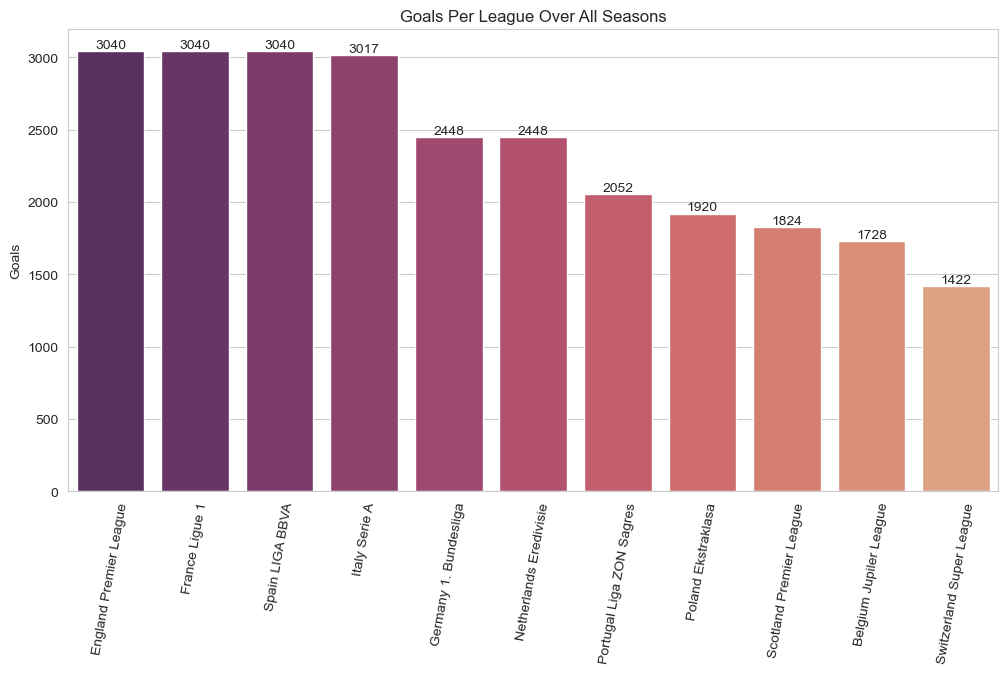

In [33]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df_goals, 
    x="name", 
    y="goals", 
    palette="flare_r")

ax.bar_label(ax.containers[0])
plt.xticks(rotation=80)
plt.title("Goals Per League Over All Seasons")
ax.set(ylabel="Goals");
ax.set(xlabel=None);

We can see that 3 leagues have same amount goals over all seasons. And only league which have lowest goals.

<ul>
    <b>Most scoring leagues with 3040 goals:</b>
    <li>England Premier League</li>
    <li>France Ligue 1</li>
    <li>Spain LIGA BBVA</li>
    <b>Lest scoring league with 1422 goals:</b>
    <li>Switzerland Super League</li>
</ul>

#### Which 5 teams scores most and less goals.

In addition we can get most and least valuable teams by goal count.

In [34]:
team_df = pd.melt(df_league,
                    id_vars=[],
                    value_vars=["home_team", "away_team"],
                    var_name="team_column",
                    value_name="team")
goals_df = pd.melt(df_league,
                   id_vars=[],
                   value_vars=["home_team_goal", "away_team_goal"],
                   var_name="goals_column",
                   value_name="goals")

combined_df = pd.concat([team_df["team"], goals_df["goals"]], axis=1)

team_goals = combined_df.groupby(
    "team")["goals"].sum().reset_index().sort_values(by=["goals"],
                                                     ascending=False)

team_of_5 = pd.concat([team_goals.head(5), team_goals.tail(5)])

C:\Users\wwric\AppData\Local\Temp\ipykernel_14016\1183629639.py:6: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  goals_df = pd.melt(df_league,


In [35]:
team_of_5.T

,75,211,49,77,184,16,264,78,56,5
team,FC Barcelona,Real Madrid CF,Celtic,FC Bayern Munich,PSV,Amadora,Trofense,FC Dordrecht,Córdoba CF,AC Arles-Avignon
goals,849,843,695,653,652,26,25,24,22,21


As we can see 10 teams, 5 teams with high goal count other 5 with low, which is good indicator which teams could potentially win more often.

#### Who are the top scorers?

To find MVP players we need to create new SQL query. As we know Match table consists of missing values. In this case we will get data only from rows which have any data.

In [36]:
# Creating df only from goal feature to parse it xml and taking only non missing values.
df_goal_xml = sql_query("""
SELECT goal
FROM Match
WHERE goal IS NOT NULL
""")

In [37]:
player1_count = defaultdict(int)

for index, row in df_goal_xml.iterrows():
    # Parse the XML string with BeautifulSoup
    soup = BeautifulSoup(row["goal"], "xml")
    
    # Find all <value>
    values = soup.find_all("value")
    
    # Loop through each <value>
    for value in values:
        # Check if <stats><goals> contains the value '1'
        goals_tag = value.find("goals")
        
        if goals_tag and int(goals_tag.text.strip()) == 1:
            # If it's a goal, find the <player1> tag
            player1_tag = value.find("player1")
            
            if player1_tag:  # If the <player1> tag exists
                player1_value = player1_tag.text.strip()  # Get the text value
                player1_count[player1_value] += 1

# Convert the defaultdict to a sorted dictionary
player1_count = dict(sorted(
    player1_count.items(),
    key=lambda x: x[1],
    reverse=True))

# Create a DataFrame with the sorted counts
df_best_players = pd.DataFrame(list(player1_count.items()),
                               columns=["player_id", "score"])

# Ensure the 'player_id' column is treated as an integer
df_best_players["player_id"] = df_best_players["player_id"].astype("int")

In [38]:
# Geting only the names of players for joining with score
df_top_players = sql_query("""
SELECT player_api_id, player_name
FROM Player
""")

df_mvp_players = pd.merge(df_best_players,
                          df_top_players,
                          left_on="player_id",
                          right_on="player_api_id",
                          how="left")

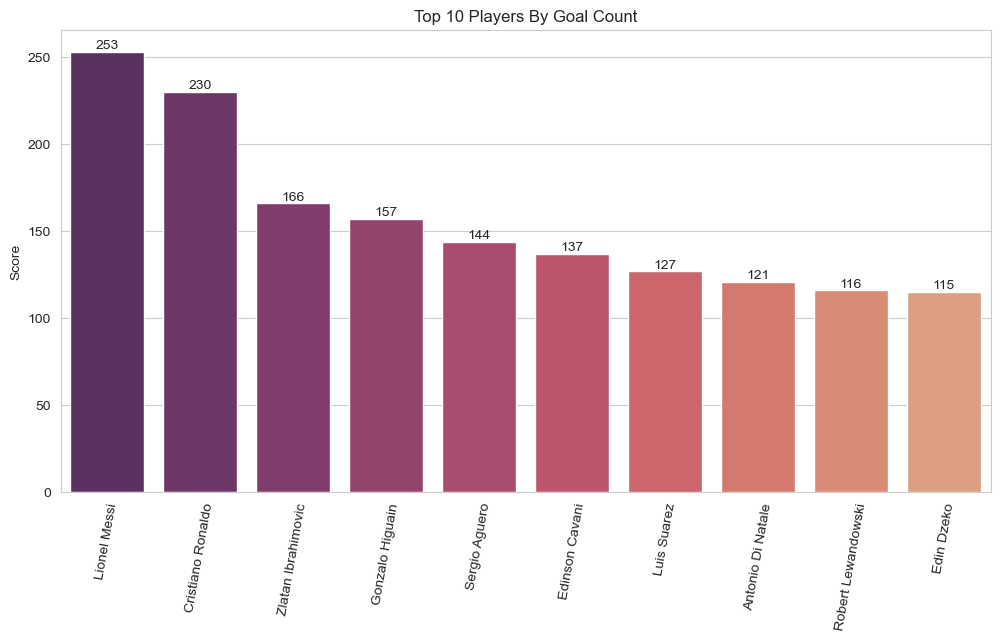

In [39]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df_mvp_players.head(10),
    x="player_name", 
    y="score",
    palette="flare_r")

ax.bar_label(ax.containers[0])
plt.xticks(rotation=80)
plt.title("Top 10 Players By Goal Count")
ax.set(ylabel="Score");
ax.set(xlabel=None);

As we can see top players with goal counts per all seasons shown in table.
<li>Top 1 scorer - Lionel Messi</li>
<li>Top 2 scorer - Cristiano Ronaldo</li>
<li>Top 3 scorer - Zlatan Ibrahimovic</li>

### Players

We will save data from Player table to data frame as it is not very complex one and also add weight as kg as a new column.

In [40]:
df_player = sql_query("""
SELECT *, (weight / 2.20462) AS weight_kg
FROM Player
""")

In [41]:
df_player.describe()

,id,player_api_id,player_fifa_api_id,height,weight,weight_kg
count,11060.000000,11060.000000,11060.000000,11060.000000,11060.000000,11060.000000
mean,5537.511392,156582.427215,165664.910488,181.867445,168.380289,76.376105
std,3197.692647,160713.700624,58649.928360,6.369201,14.990217,6.799456
min,1.000000,2625.000000,2.000000,157.480000,117.000000,53.070370
25%,2767.750000,35555.500000,151889.500000,177.800000,159.000000,72.121273
50%,5536.500000,96619.500000,184671.000000,182.880000,168.000000,76.203609
75%,8306.250000,212470.500000,203883.250000,185.420000,179.000000,81.193131
max,11075.000000,750584.000000,234141.000000,208.280000,243.000000,110.223077


From statistical view we can see that player measures are nicely distributed without any anomalies and outliers. We will go deeper about these values in our analysis. 

####  Players  birth

First of all we can see when players from our dataset have been born and they body measurements.

In [42]:
df_player["birthday"] = pd.to_datetime(df_player["birthday"])
df_player["birth_year"] = df_player["birthday"].dt.year

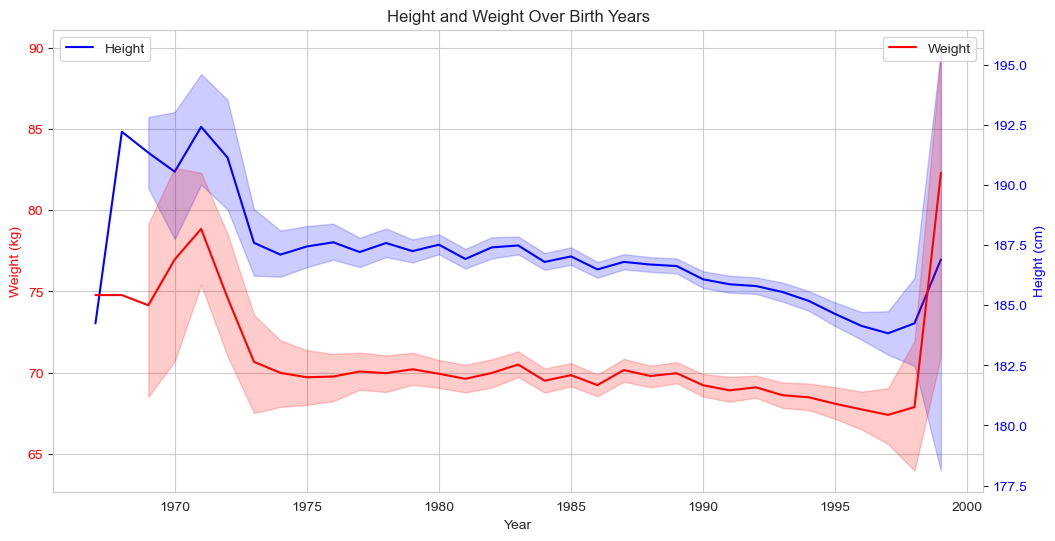

In [43]:
fig, ax1 = plt.subplots(figsize=(12,6))

sns.lineplot(data=df_player, x="birth_year", y="weight_kg", color="b", label="Height", ax=ax1)
ax1.set_xlabel("Year")
ax1.set_ylabel("Weight (kg)", color="r")
ax1.tick_params(axis="y", labelcolor="r")

ax2 = ax1.twinx()
sns.lineplot(data=df_player, x="birth_year", y="height", color="r", label="Weight", ax=ax2)
ax2.set_ylabel("Height (cm)", color="b")
ax2.tick_params(axis="y", labelcolor="b")

ax1.legend(loc="upper left") 
ax2.legend(loc="upper right")
ax2.grid(False)

plt.title("Height and Weight Over Birth Years")
plt.show();

From line plot we can see that our data from player database starts at about 1967 in which player body measures rise and soon later start decrease over years, only from about 1998 body measures increase start appearing.

####  Players height vs weight

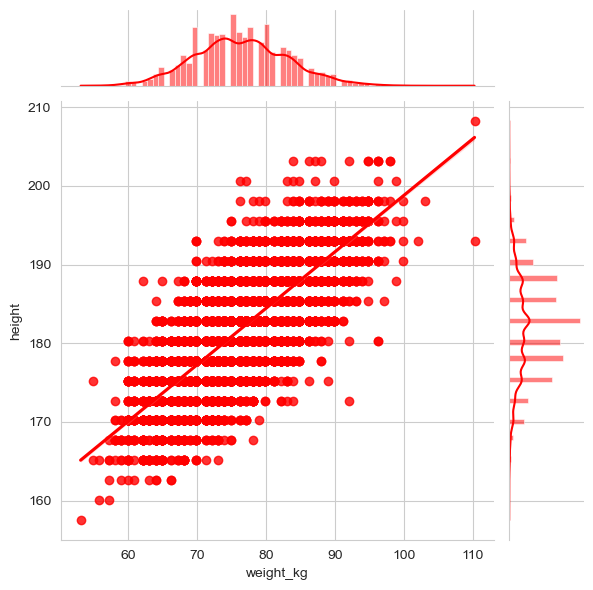

In [44]:
sns.jointplot(data=df_player, x="weight_kg", y="height", kind="reg", color="r");

As we see body measurements are nicely distributed. Body weight increase with height.

<Figure size 1200x600 with 0 Axes>

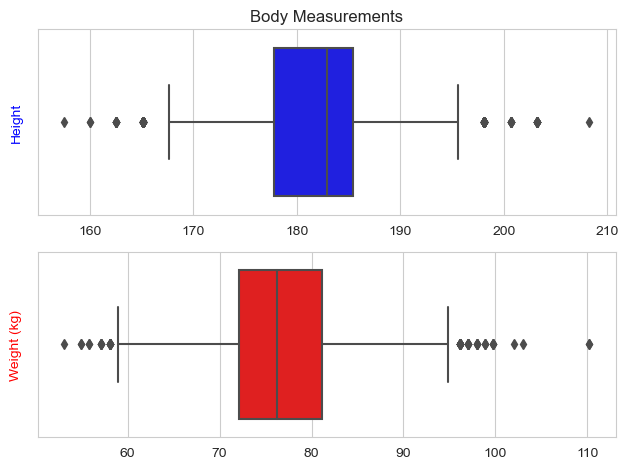

In [45]:
plt.figure(figsize=(12, 6))
fig, (ax1, ax2) = plt.subplots(2, 1)

# Box plot fot height
sns.boxplot(
    data=df_player, 
    x="height", 
    ax=ax1, 
    color="b")

# Box plot for weight
sns.boxplot(
    data=df_player, 
    x="weight_kg", 
    ax=ax2, 
    color="r")

ax1.set(xlabel=None)
ax2.set(xlabel=None)

ax1.set_ylabel("Height", color="b")
ax2.set_ylabel("Weight (kg)", color="r")

ax1.set_title("Body Measurements")
plt.tight_layout()

<ul>
    <li>Most of the player are 167-197 cm height.</li>
    <li>Average height ~ 183 cm.</li>
    <li>Most of the player are 59-97 kg weight</li>
    <li>Average weight ~ 77 kg.</li>
    <li>We can see outliers in data which is very tall or heavy players but we can assume those are Gaol Keepers.</li>
</ul>

#### Player overall rating vs potential

In [46]:
df_player_attributes_rating = sql_query("""
SELECT 
    player_api_id, 
    AVG(overall_rating) AS overall, 
    AVG(potential) AS potential
FROM Player_attributes
GROUP BY player_api_id
ORDER BY date
""")

<Figure size 1200x600 with 0 Axes>

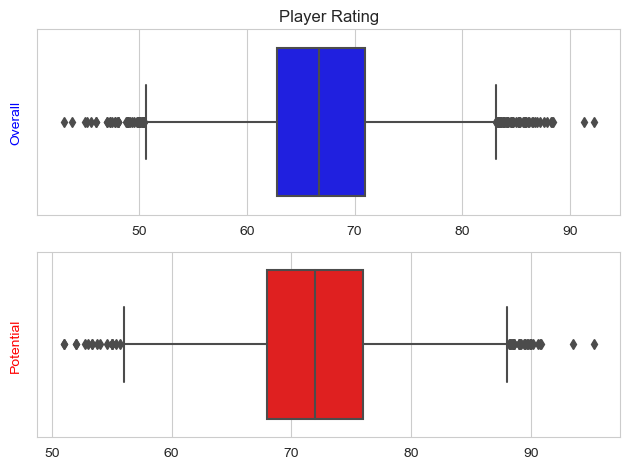

In [47]:
plt.figure(figsize=(12, 6))
fig, (ax1, ax2) = plt.subplots(2, 1)

# Box plot fot height
sns.boxplot(
    data=df_player_attributes_rating, 
    x="overall", 
    ax=ax1, 
    color="b")

# Box plot for weight
sns.boxplot(
    data=df_player_attributes_rating, 
    x="potential", 
    ax=ax2, 
    color="r")

ax1.set(xlabel=None)
ax2.set(xlabel=None)

ax1.set_ylabel("Overall", color="b")
ax2.set_ylabel("Potential", color="r")

ax1.set_title("Player Rating")
plt.tight_layout()

<ul>
    <li>Player overall rating going from 51 to 83.</li>
    <li>Average overall rating ~ 67.</li>
    <li>Player potential going from 56 to 88.</li>
    <li>Average potential ~ 72.</li>
    <li>On average player differs from potential with 5.</li>
    <li>While checking player Overall and Potential rating we can also see some outliers, but because we have quite large dataset it is possible that MVP or Junior players change overall distribution.</li>
</ul>

We can also see correlation between player attributes. For this we will also join player body measurements.

In [48]:
df_player_attributes = sql_query("""
SELECT 
    DATE(Player.birthday) AS date,
    Player.height,
    (Player.weight / 2.20462) AS weight_kg,
    CASE 
        WHEN preferred_foot = 'left' THEN 0
        WHEN preferred_foot = 'right' THEN 1
        ELSE NULL
    END AS preferred_foot,
    Player_Attributes.overall_rating, 
    Player_Attributes.potential,
    Player_Attributes.attacking_work_rate,
    Player_Attributes.defensive_work_rate,
    Player_Attributes.crossing,
    Player_Attributes.finishing,
    Player_Attributes.heading_accuracy,
    Player_Attributes.short_passing,
    Player_Attributes.volleys,
    Player_Attributes.dribbling,
    Player_Attributes.curve,
    Player_Attributes.free_kick_accuracy,
    Player_Attributes.long_passing,
    Player_Attributes.ball_control,
    Player_Attributes.acceleration,
    Player_Attributes.sprint_speed,
    Player_Attributes.agility,
    Player_Attributes.reactions,
    Player_Attributes.balance,
    Player_Attributes.shot_power,
    Player_Attributes.jumping,
    Player_Attributes.stamina,
    Player_Attributes.strength,
    Player_Attributes.long_shots,
    Player_Attributes.aggression,
    Player_Attributes.interceptions,
    Player_Attributes.positioning,
    Player_Attributes.vision,
    Player_Attributes.penalties,
    Player_Attributes.marking,
    Player_Attributes.standing_tackle,
    Player_Attributes.sliding_tackle,
    Player_Attributes.gk_diving,
    Player_Attributes.gk_handling,
    Player_Attributes.gk_kicking,
    Player_Attributes.gk_positioning,
    Player_Attributes.gk_reflexes
FROM 
    Player
JOIN 
    Player_Attributes 
ON 
    Player.player_api_id = Player_Attributes.player_api_id
""")

In [49]:
# Droping NAN rows
df_player_attributes = df_player_attributes.dropna(axis=0, how='any')

In [50]:
df_player_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
height,180354.0,181.877895,6.398588,157.48000,177.800000,182.880000,185.420000,208.280000
weight_kg,180354.0,76.554959,6.848522,53.07037,72.121273,76.203609,81.193131,110.223077
preferred_foot,180354.0,0.755442,0.429826,0.00000,1.000000,1.000000,1.000000,1.000000
overall_rating,180354.0,68.635317,7.027950,33.00000,64.000000,69.000000,73.000000,94.000000
potential,180354.0,73.479457,6.581963,39.00000,69.000000,74.000000,78.000000,97.000000
crossing,180354.0,55.142071,17.247231,1.00000,45.000000,59.000000,68.000000,95.000000
finishing,180354.0,49.962136,19.041760,1.00000,34.000000,53.000000,65.000000,97.000000
heading_accuracy,180354.0,57.263476,16.478716,1.00000,49.000000,60.000000,68.000000,98.000000
short_passing,180354.0,62.486726,14.172493,3.00000,57.000000,65.000000,72.000000,97.000000
volleys,180354.0,49.488927,18.252319,1.00000,35.000000,52.000000,64.000000,93.000000


From statistical view we don't see any outliers, numbers scales without any anomalies in all columns, we can proceed further.

In [51]:
corr = df_player_attributes.corr()

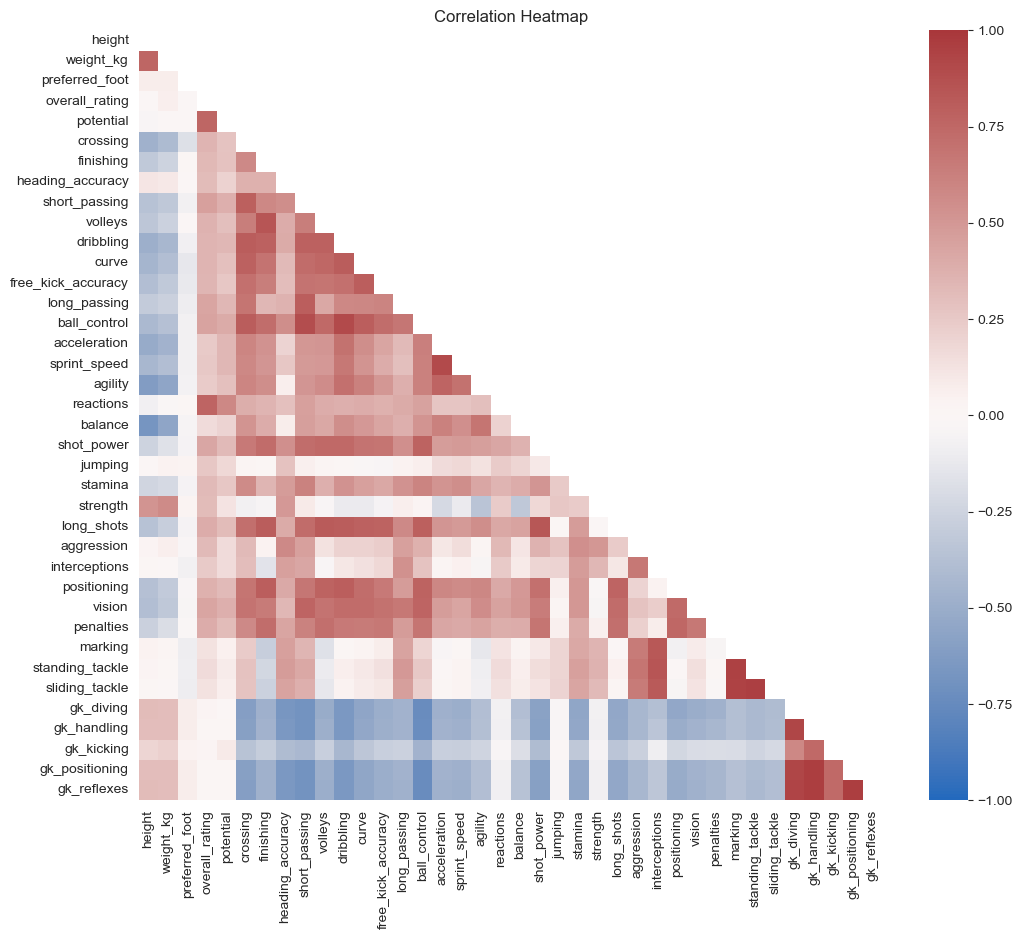

In [52]:
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, 
            mask=mask, 
            vmin=-1, 
            vmax=1, 
            cmap="vlag")

plt.title("Correlation Heatmap");

<li>As we see a lot of features positively and negatively correlates between each other. Body measurements from Player table have negative correlation with almost all features from Player Attributes.</li>
<li>Goal Keeper is the only player which have positive relationship with height and weight of the player.</li>
<li>Best Goal Keeper is biggest player in team, with good positioning, reflexes.</li>
<li>Also in other hand best player is smallest person, which control ball most of the time.</li>
<li>Standing and sliding tackle have high correlation with penalties and marking.</li>
<li>Positioning is also one of the important things which correlate with finishing.</li>
<li>Player with good marking, tackle are better for interceptions.</li>

### Match 

First it will be good idea to get basic information about matches per season.

In [53]:
df_match_date = sql_query("""
SELECT 
    strftime('%m', date) AS month,
    count(date) AS count
FROM Match
GROUP BY month
""")

In [54]:
# Map numbers with month names
df_match_date['month'] = df_match_date['month'].astype(int).apply(
    lambda x: calendar.month_name[x])

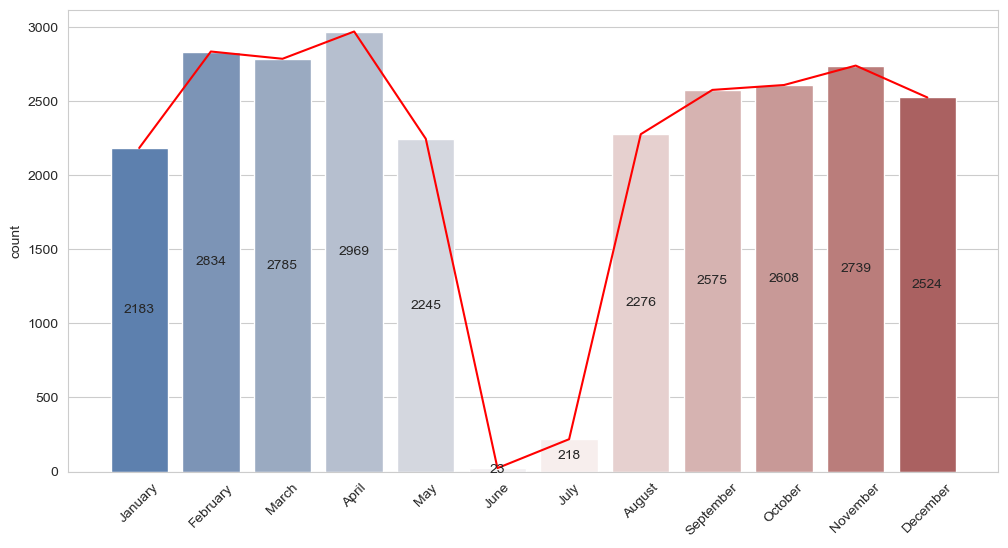

In [55]:
plt.figure(figsize=(12, 6))
ax1 = sns.barplot(data=df_match_date, x="month", y="count", palette="vlag")
ax2 = sns.lineplot(data=df_match_date, x="month", y="count", color="r")

ax1.bar_label(ax1.containers[0], label_type="center")
plt.xticks(rotation=45)
plt.xlabel(None);

<li>Lowest count of games appears to be on June and July due to break between seasons.</li>
<li>In spring we can see the biggest numbers of games per all seasons due to ending of season.</li>

#### Is there such a thing as home advantage?

To answer this question we will use Chi-Square Test for Goodness-of-Fit witch is a statistical hypothesis test used to determine whether a variable is likely to come from a specified distribution or not.

Null Hypothesis (H0): The observed distribution of match results ("Home Win," "Tie," "Away Win") is consistent with the expected distribution, where each outcome occurs with a proportion of 1/3.

Alternative Hypothesis (H1): The observed distribution of match results is significantly different from the expected distribution, indicating that the outcomes are not equally likely.

We will set a 95% confidence level and check if it rejects the null hypothesis.

The α value is a threshold we will set, by which it says that the probability of observing a result as extreme or more (p-value) is lower than α, then we reject the null hypothesis. Our α = 0.05, so our confidence (1 - α) is 95%.

In [56]:
df_league["result"] = df_league.apply(get_match_result, axis=1)

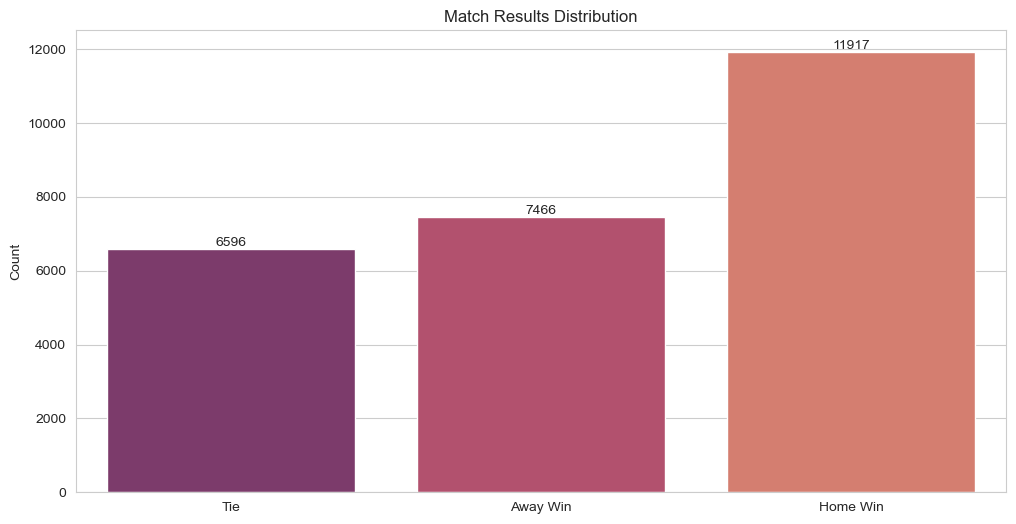

Chi-Square Statistic: 1881.57
P-value: 0.0000
Reject the null hypothesis. The observed distribution is significantly different from expected.


In [57]:
observed_counts = df_league["result"].value_counts()

# Define ouput by 1/3 chance
expected_counts = [len(df_league) / 3] * 3

# Perform a chi-square test for goodness-of-fit
chi_result = chisquare(f_obs=observed_counts, f_exp=expected_counts)

plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df_league, x="result", palette="flare_r")

ax.bar_label(ax.containers[0])
plt.title("Match Results Distribution")
plt.xlabel(None)
plt.ylabel("Count")
plt.show()

print(f"Chi-Square Statistic: {chi_result.statistic:.2f}")
print(f"P-value: {chi_result.pvalue:.4f}")

# Check if we reject or fail to reject the null hypothesis
if chi_result.pvalue < 0.05:
    print("Reject the null hypothesis. The observed distribution is significantly different from expected.")
else:
    print("Fail to reject the null hypothesis. The observed distribution is not significantly different from expected.")

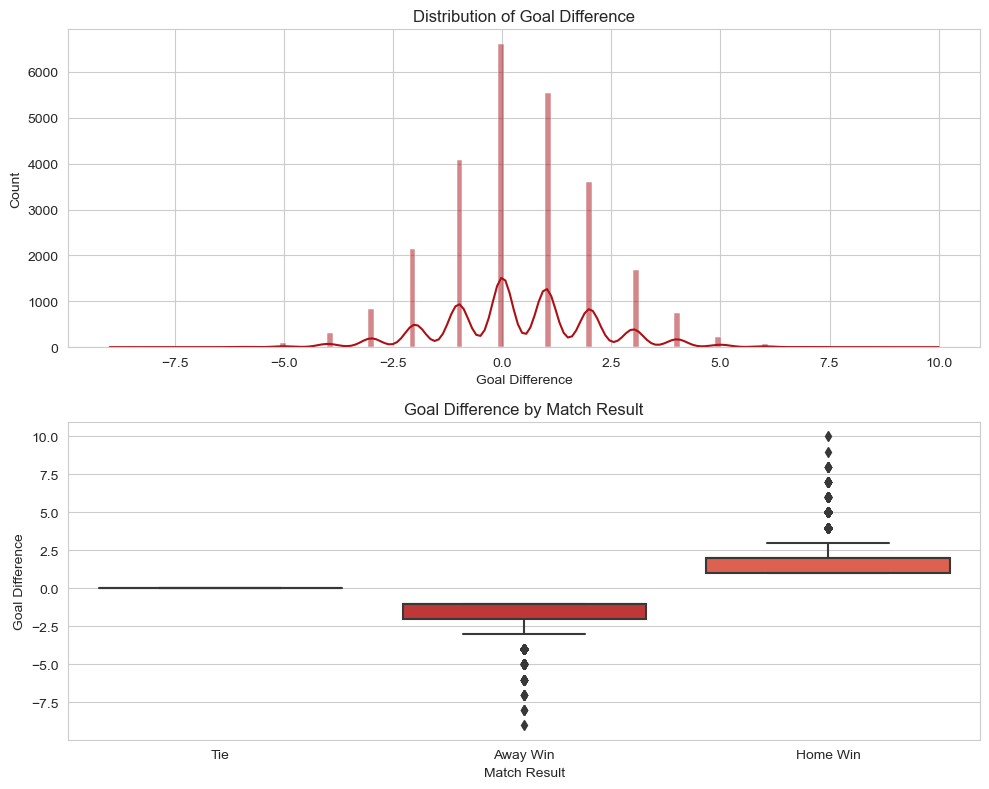

In [58]:
# Calculate goal difference
df_league["goal_difference"] = df_league["home_team_goal"] - df_league["away_team_goal"]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

sns.histplot(df_league['goal_difference'], kde=True, ax=ax1)
sns.boxplot(data=df_league, x='result', y='goal_difference', ax=ax2)

ax1.set_xlabel("Goal Difference")
ax1.set_title("Distribution of Goal Difference")
ax2.set_title("Goal Difference by Match Result")
ax2.set_xlabel("Match Result")
ax2.set_ylabel("Goal Difference")
plt.tight_layout();

<li>Tie in a match appears most of the times where goal difference is 0.</li>
<li>We can see right skew data which means that on average home teams goal count higher.</li>
<li>On average match ends with 1-2 score difference.</li>
<li>We can see outliers in both teams. There are cases then both teams score more than 5 and even 10 goals per match.</li>

### Team

Team table don't have a lot of useful information so we will work with Team Attributes table.

In [59]:
df_team = sql_query("""
SELECT 
    team_api_id, 
    STRFTIME('%Y', date) AS date,
    buildUpPlaySpeed,  
    buildUpPlayPassing, 
    chanceCreationPassing, 
    chanceCreationCrossing, 
    chanceCreationShooting, 
    defencePressure, 
    defenceAggression, 
    defenceTeamWidth,
    (buildUpPlaySpeed + buildUpPlayPassing) / 2.0 AS avg_buildUpPlay,
    (chanceCreationPassing + chanceCreationCrossing + chanceCreationShooting) / 3.0 AS avg_chanceCreation,
    (defencePressure + defenceAggression + defenceTeamWidth) / 3.0 AS avg_defence
FROM Team_Attributes
ORDER by date
""")

In [60]:
df_team.describe().T

,count,mean,std,min,25%,50%,75%,max
team_api_id,1458.0,9995.727023,13264.869900,1601.000000,8457.750000,8674.000000,9904.000000,274581.000000
buildUpPlaySpeed,1458.0,52.462277,11.545869,20.000000,45.000000,52.000000,62.000000,80.000000
buildUpPlayPassing,1458.0,48.490398,10.896101,20.000000,40.000000,50.000000,55.000000,80.000000
chanceCreationPassing,1458.0,52.165295,10.360793,21.000000,46.000000,52.000000,59.000000,80.000000
chanceCreationCrossing,1458.0,53.731824,11.086796,20.000000,47.000000,53.000000,62.000000,80.000000
chanceCreationShooting,1458.0,53.969136,10.327566,22.000000,48.000000,53.000000,61.000000,80.000000
defencePressure,1458.0,46.017147,10.227225,23.000000,39.000000,45.000000,51.000000,72.000000
defenceAggression,1458.0,49.251029,9.738028,24.000000,44.000000,48.000000,55.000000,72.000000
defenceTeamWidth,1458.0,52.185871,9.574712,29.000000,47.000000,52.000000,58.000000,73.000000
avg_buildUpPlay,1458.0,50.476337,9.374773,23.000000,44.500000,50.500000,57.000000,75.000000


<li>On average all team attributes goes from 46 to 54</li>
<li>Minimum attributes stay at about 20.</li>
<li>Maximum attributes reach 80.</li>
<li>STD stays at about 10.</li>

#### Build up class distribution over seasons

In [61]:
df_buildup = df_team[[
    "date", 
    "buildUpPlaySpeed", 
    "buildUpPlayPassing", 
    "avg_buildUpPlay"]]

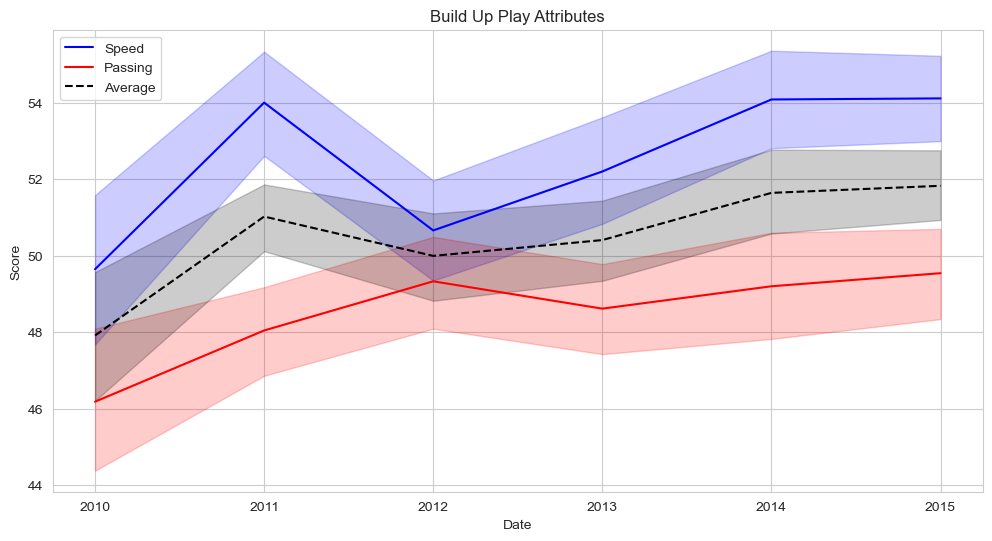

In [62]:
plt.figure(figsize=(12, 6))
plot_multiple_lines(df_buildup, "date", buildup_attributes)
plt.title("Build Up Play Attributes")
plt.ylabel("Score")
plt.xlabel("Date");

<li>On average all build up classes increases over time.</li>
<li>We can see few point increase of Play Speed in 2010-2011 while it decrease in other season.</li>

#### Chance creation class distribution over seasons

In [63]:
df_chancecreation = df_team[[
    "date", 
    "chanceCreationPassing", 
    "chanceCreationCrossing", 
    "chanceCreationShooting", 
    "avg_chanceCreation"]]

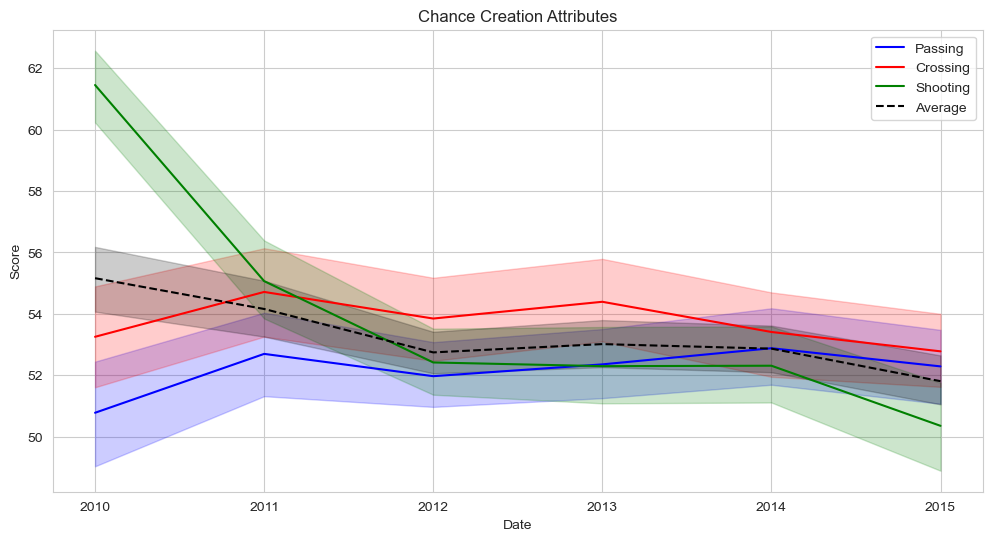

In [64]:
plt.figure(figsize=(12, 6))
plot_multiple_lines(df_chancecreation, "date", chancecreation_attributes)
plt.title("Chance Creation Attributes")
plt.ylabel("Score")
plt.xlabel("Date");

<li>We can see that shooting decrease over time from ~62 to ~51.</li>
<li>While other attributes increase in few points whey also start decreasing over time.</li>
<li>On average Chance Creation decrease over time.</li>

#### Defence class distribution over seasons

In [65]:
df_defence = df_team[[
    "date", 
    "defencePressure", 
    "defenceAggression", 
    "defenceTeamWidth", 
    "avg_defence"]]

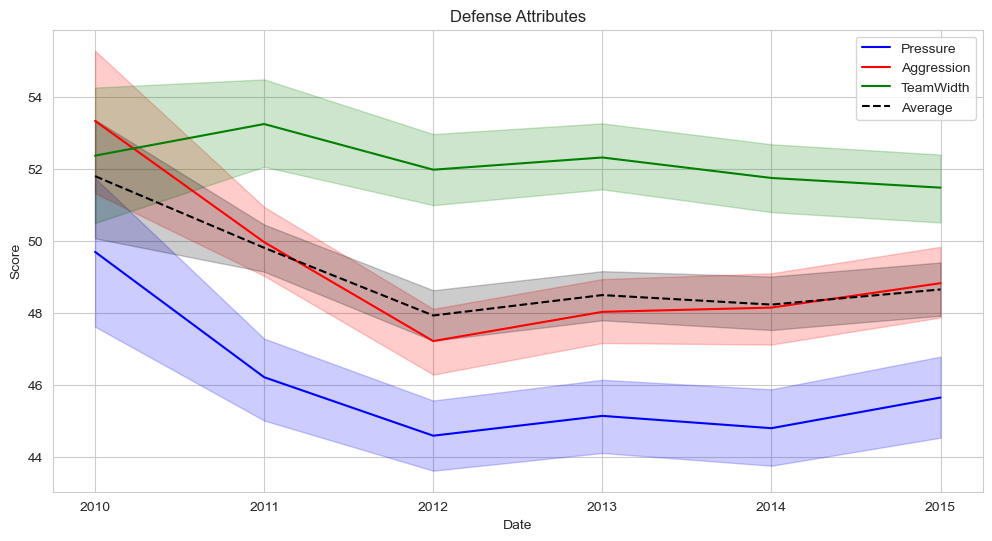

In [66]:
plt.figure(figsize=(12, 6))
plot_multiple_lines(df_defence, "date", defense_attributes)
plt.title("Defense Attributes")
plt.ylabel("Score")
plt.xlabel("Date");

<li>We can see that Pressure and Aggression decrease from start until 2012, from there it start increase slowly.</li>
<li>Team Width Increase by 0.5 point and also by the seasons decrease.</li>
<li>Overall we see attributes decrease by few points from 2010 till 2012. And slow increasing again until end of all seasons.</li>

### Can we predict how many goals each team will score in each match or which team will win the match?

Before going to prediction we will clean our memory by removing unnecessary data frames.

For predictions we will create one more dataframe which consists of results of the match.

In [67]:
df_match = sql_query("""
SELECT 
    home_team_api_id, 
    away_team_api_id, 
    home_team_goal, 
    away_team_goal,
    CASE 
        WHEN home_team_goal > away_team_goal THEN 1
        WHEN home_team_goal < away_team_goal THEN -1
        ELSE 0
    END AS result
FROM Match
""")

We will combine main table of match with team table to have team attributes for both home and away team.

In [68]:
df_team = df_team.groupby(["team_api_id"]).mean() # Calculating mean of all seasons

In [69]:
# Join for home team
df_dummy = pd.merge(df_match,
                   df_team,
                   left_on=["home_team_api_id"],
                   right_on=["team_api_id"],
                   how="left")

# Join for away team
df_dummy = pd.merge(df_dummy,
                   df_team,
                   left_on=["away_team_api_id"],
                   right_on=["team_api_id"],
                   how="left")

As we know some teams don't have team attributes for all seasons, so we will drop all rows which consists of any missing value and also remove duplicate columns.

In [70]:
# Droping missing values
df_pred = df_dummy.dropna(axis=0, how="any")

In [71]:
# Clearing the memory
del (df_leagues, df_league, df_goals, team_df, goals_df, 
    combined_df, team_goals, team_of_5, df_goal_xml, df_best_players, 
    df_top_players, df_mvp_players, df_player, df_player_attributes_rating,
    df_player_attributes, df_match_date, df_team, df_chancecreation, df_defence)

In [72]:
# Define features and target variables for home/away teams
y_home_goal = df_pred["home_team_goal"]
y_away_goal = df_pred["away_team_goal"]
y_match_result = df_pred["result"]

features = list(df_pred.columns)
features_to_remove = ["home_team_api_id", "away_team_api_id", "home_team_goal", "away_team_goal", "result"]
features = list(filter(lambda x: x not in features_to_remove, features))


X = df_pred[features]

In [73]:
# Splitting for goal prediction
X_train, X_test, y_home_train, y_home_test = train_test_split(X,
                                                              y_home_goal,
                                                              test_size=0.15,
                                                              random_state=10)
_, _, y_away_train, y_away_test = train_test_split(
    X, y_away_goal, test_size=0.15,
    random_state=42)  # Using same x, y train values

# Splitting for outcome prediction
X_train_res, X_test_res, y_res_train, y_res_test = train_test_split(
    X, y_match_result, test_size=0.15, random_state=10)

In [74]:
# Home team goals LG
home_goal_model = LinearRegression()
home_goal_model.fit(X_train, y_home_train)

# Away team goals LG
away_goal_model = LinearRegression()
away_goal_model.fit(X_train, y_away_train)

# Match outcomes LG
outcome_model = LogisticRegression(max_iter=1000)
outcome_model.fit(X_train_res, y_res_train)

LogisticRegression(max_iter=1000)

In [75]:
# Performance of model (home goals)
home_goal_pred = home_goal_model.predict(X_test)
home_mae = mean_absolute_error(y_home_test, home_goal_pred)
home_mse = mean_squared_error(y_home_test, home_goal_pred)
home_rmse = np.sqrt(home_mse)

# Performance of model (away goals)
away_goal_pred = away_goal_model.predict(X_test)
away_mae = mean_absolute_error(y_away_test, away_goal_pred)
away_mse = mean_squared_error(y_away_test, away_goal_pred)
away_rmse = np.sqrt(away_mse)

# Performance of model (outcome prediction)
outcome_pred = outcome_model.predict(X_test_res)
outcome_accuracy = accuracy_score(y_res_test, outcome_pred)
outcome_confusion_matrix = confusion_matrix(y_res_test, outcome_pred)

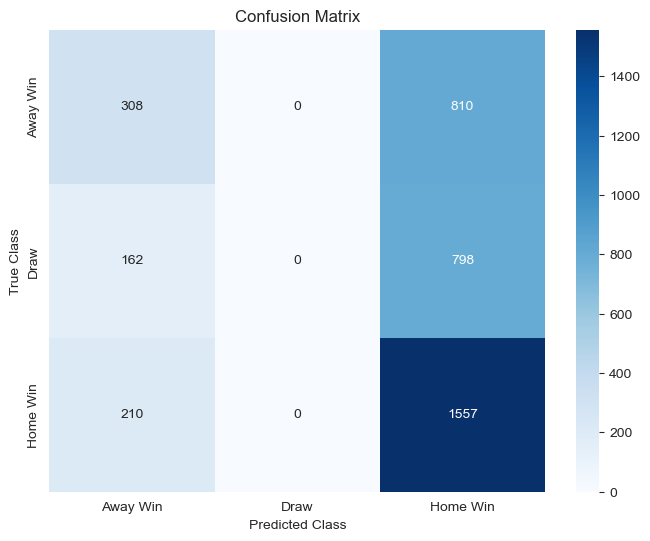

Home Goals - MAE: 1.016283793712067 MSE: 1.6074906604608683 RMSE: 1.2678685501505542
Away Goals - MAE: 0.8856572272475906 MSE: 1.2669329215218825 RMSE: 1.1255811483504343
Outcome Prediction - Accuracy: 0.4850455136540962


In [76]:
class_names = ["Away Win", "Draw", "Home Win"]

plt.figure(figsize=(8, 6))  # Adjust size as needed
sns.heatmap(
    outcome_confusion_matrix,
    annot=True,  # Annotate with counts
    fmt='d',  # Integer format
    cmap='Blues', 
    xticklabels=class_names, 
    yticklabels=class_names
)

# Add labels and title
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

print("Home Goals - MAE:", home_mae, "MSE:", home_mse, "RMSE:", home_rmse)
print("Away Goals - MAE:", away_mae, "MSE:", away_mse, "RMSE:", away_rmse)
print("Outcome Prediction - Accuracy:", outcome_accuracy)

An accuracy of 48.50% (approximately 0.485) means the model is correct about 49% of the time when predicting whether the match result will be a home win, away win, or draw. Without adding players to teams, only base by team attributes accuracy is average for this model.

On average predicting goals is about 1.26 off for Home team and 1.12 for Away team.

## Summary

<b>Data Cleaning</b>
    <li>We didn't found any duplicates in our dataset.</li>
    <li>Our data consist of a lot of missing values but we deal with them only if needed in EDA.</li>
    <li>We drop column buildUpPlayDribbling of missing values of table Team Attributes</li>
    
    
<b>Exploratory Data Analysis</b>
    <li>We can see that we have 11 different countries with one league per country. All of league names begins with associate country name.</li>
    <li>We have 3 top most scoring leagues with goal count of 3040: England Premier League, France Ligue 1, Spain LIGA BBVA</li>
    <li>Top 3 teams by goal count: FC Barcelona, Real Madrid, CF Celtic.</li>
    <li>Top 3 Player by goal count: Lionel Messi, Cristiano Ronaldo, Zlatan Ibrahimovic</li>
    <li>Average player height ~ 183 cm, weight ~77 Kg.</li>
    <li>As we see a lot of features positively and negatively correlates between each other. Body measurements from Player table have negative correlation with almost all features from Player Attributes.</li>
    <li>Goal Keeper is the only player which have positive relationship with height and weight of the player.</li>
    <li>Best Goal Keeper is biggest player in team, with good positioning, reflexes.</li>
    <li>Also in other hand best player is smallest person, which control ball most of the time.</li>
    <li>Standing and sliding tackle have high correlation with penalties and marking.</li>
    <li>Positioning is also one of the important things which correlate with finishing.</li>
    <li>On average match ends with 1-2 score difference. There are maches in which difference are 10 goals.</li>
    <li>We found out that there is a Home advantage.</li>
    <li>Build up and Defense attributes increase overtime, while Chance Creation decrease.</li>


<b>Machine learning</b>
    <li>We can predict goal count for Home and Away team by 1.12 - 1.26 off goals.</li>
    <li>Our model works on average for predicting the outcome of match.</li>    

## Recommendations

Recommendation for business:
<li>Tallest player with best reflexes good for Goal Keeper position.</li>
<li>Playing in top Leagues indicate higher difficulty to play due more intense game.</li>
<li>Players with higher reaction indicates higher overall rating of attributes.</li>
<li>Player with good marking, tackle are better for interceptions</li>

## Suggestion For Impovement

The analysis can be improved in a couple of ways:
    <li>Try different ML models and adjust their configuration to find better fit.</li>
    <li>Try combining each play with corresponding players and their attributes.</li>
    <li>Deal with high influence outliers.</li>